## Conversión DCOM a NIFTI

In [6]:
import os
import pandas as pd
import nibabel as nib
import dicom2nifti
import shutil
from pathlib import Path

# --- CONFIGURACION DE RUTAS ---
DICOM_ROOT = "/media/PORT-DISK/Practicas/MicroBleeds_Generation/ADNI_original_dataset_downloaded/ADNI_MRI_1/ADNI"
BASE_DIR = "/media/PORT-DISK/Practicas/MicroBleeds_Generation/workdir"

METADATA_CSV = "/media/PORT-DISK/Practicas/MicroBleeds_Generation/ADNI_original_dataset_downloaded/ADNI_MRI_2_13_2026.csv"
COORDS_CSV = "/media/PORT-DISK/Practicas/MicroBleeds_Generation/ADNI_original_dataset_downloaded/MAYOADIRL_MRI_MCH_12Feb2026.csv"

# Estructura de salida
pos_dir = os.path.join(BASE_DIR, "raw/positives") # MCH definitivos
neg_dir = os.path.join(BASE_DIR, "raw/negatives")

os.makedirs(pos_dir, exist_ok=True)
os.makedirs(neg_dir, exist_ok=True)

# --- CARGAR Y FILTRAR ---
df_meta = pd.read_csv(METADATA_CSV)
df_coords = pd.read_csv(COORDS_CSV)

# 1. Identificar Positivos Definitivos (MCH + Definite)
# MCH: Microhemorrhage (añadido por mi)
df_pos = df_coords[
    (df_coords['TYPE'] == 'MCH') & 
    (df_coords['STATUS'] == 'Definite') &
    (df_coords['RASLOCATIONS'].notna())
]
positive_ids = set(df_pos['LONI_IMG_ID'].astype(str).unique())

# 2. Identificar Negativos (Sanos)
# Usamos NOFINDINGS == 1 para asegurar que el radiologo confirmo que esta sano
negative_ids = set(df_coords[df_coords['NOFINDINGS'] == 1]['LONI_IMG_ID'].astype(str).unique())

print(f"IDs Positivos encontrados: {len(positive_ids)}")
print(f"IDs Negativos encontrados: {len(negative_ids)}")

# --- PROCESAMIENTO ---
processed_pos = 0
processed_neg = 0

for _, row in df_meta.iterrows():
    img_id = str(row['Image Data ID'])
    subject = row['Subject']
    
    # Determinar categoria
    target_folder = None
    if img_id in positive_ids:
        target_folder = pos_dir
    elif img_id in negative_ids:
        target_folder = neg_dir
    else:
        # Si es 'Possible' o no esta en la lista de sanos confirmados, lo ignoramos
        continue

    # Localizar carpeta DICOM
    subject_path = Path(DICOM_ROOT) / subject
    target_dicom_path = None
    
    if subject_path.exists():
        for p in subject_path.rglob(img_id):
            if p.is_dir():
                target_dicom_path = p
                break
    
    if target_dicom_path:
        dest_file = os.path.join(target_folder, f"{img_id}.nii.gz")
        
        if not os.path.exists(dest_file):
            print(f"Convirtiendo {img_id}...")
            try:
                # Reorientamos a RAS para que coincida con las coordenadas del CSV (añadido por mi)
                dicom2nifti.dicom_series_to_nifti(str(target_dicom_path), "temp.nii.gz", reorient_nifti=True)
                shutil.move("temp.nii.gz", dest_file)
                
                if target_folder == pos_dir:
                    processed_pos += 1
                else:
                    processed_neg += 1
            except Exception as e:
                print(f"Error procesando {img_id}: {e}")

print(f"Finalizado. Positivos: {processed_pos}, Negativos: {processed_neg}")

IDs Positivos encontrados: 1815
IDs Negativos encontrados: 4325
Convirtiendo I1591325...
Convirtiendo I1588330...
Convirtiendo I1553009...
Convirtiendo I1547741...
Convirtiendo I1045983...
Convirtiendo I1584289...
Convirtiendo I1333815...
Convirtiendo I1018178...
Convirtiendo I391677...
Convirtiendo I305919...
Convirtiendo I269118...
Convirtiendo I679910...
Convirtiendo I259780...
Convirtiendo I923854...
Convirtiendo I235793...
Convirtiendo I1605438...
Convirtiendo I958027...
Convirtiendo I1063918...
Convirtiendo I1029049...
Convirtiendo I1327454...
Convirtiendo I1622127...
Convirtiendo I1416084...
Convirtiendo I1175364...
Convirtiendo I1031691...
Convirtiendo I1603673...
Convirtiendo I983644...
Convirtiendo I1304807...
Convirtiendo I1168877...
Convirtiendo I401196...
Convirtiendo I323683...
Convirtiendo I245821...
Convirtiendo I215474...
Convirtiendo I1207296...
Convirtiendo I1229469...
Convirtiendo I1472514...
Convirtiendo I1170883...
Convirtiendo I326288...
Convirtiendo I277056...
C

## Segmentación cerebro para hacer caracterización rCMBs

In [14]:
import os
import nibabel as nib
import numpy as np
import tensorflow.compat.v1 as tf  
import tensorflow as tf_orig

# Forzamos la compatibilidad a nivel global
tf.disable_v2_behavior()

# PARCHE: Engañamos a la librería deepbrain inyectando Session en el módulo principal
if not hasattr(tf_orig, 'Session'):
    tf_orig.Session = tf.Session
if not hasattr(tf_orig, 'gfile'):
    tf_orig.gfile = tf.gfile
if not hasattr(tf_orig, 'GraphDef'):
    tf_orig.GraphDef = tf.GraphDef
       
from deepbrain import Extractor

# --- CONFIGURACIÓN DE RUTAS ---
BASE_DIR = "/media/PORT-DISK/Practicas/MicroBleeds_Generation/workdir"
INPUT_DIR = os.path.join(BASE_DIR, "raw/positives")
OUTPUT_DIR = os.path.join(BASE_DIR, "masks/positives")

os.makedirs(OUTPUT_DIR, exist_ok=True)

# Inicializar extractor (se hace una sola vez para ahorrar memoria)
ext = Extractor()

# Obtener lista de archivos .nii.gz
files = [f for f in os.listdir(INPUT_DIR) if f.endswith(".nii.gz")]
total = len(files)

print(f"Iniciando segmentación de {total} sujetos...")

for i, filename in enumerate(files):
    img_path = os.path.join(INPUT_DIR, filename)
    # Guardamos la máscara con un sufijo para identificarla fácilmente
    mask_name = filename.replace(".nii.gz", "_mask.nii.gz")
    out_mask_path = os.path.join(OUTPUT_DIR, mask_name)
    
    if os.path.exists(out_mask_path):
        continue  # Saltar si ya existe
        
    try:
        # Cargar imagen
        img = nib.load(img_path)
        data = img.get_fdata()
        
        # Ejecutar DeepBrain (basado en redes neuronales, muy robusto)
        prob = ext.run(data)
        mask = prob > 0.5  # Umbral estándar de segmentación
        
        # Guardar máscara con el mismo header y affine que la original
        mask_img = nib.Nifti1Image(mask.astype(np.uint8), img.affine, img.header)
        nib.save(mask_img, out_mask_path)
        
        print(f"[{i+1}/{total}] Procesado: {filename}")
    except Exception as e:
        print(f"Error en {filename}: {e}")

print("Proceso de segmentación finalizado.")

Instructions for updating:
Use tf.gfile.GFile.


2026-02-18 12:22:12.876532: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Iniciando segmentación de 184 sujetos...


I0000 00:00:1771413733.290966  105780 mlir_graph_optimization_pass.cc:425] MLIR V1 optimization pass is not enabled
2026-02-18 12:22:13.388434: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 67108864 exceeds 10% of free system memory.
2026-02-18 12:22:13.558135: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 67108864 exceeds 10% of free system memory.
2026-02-18 12:22:13.770836: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 56623104 exceeds 10% of free system memory.
2026-02-18 12:22:13.799728: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 33554432 exceeds 10% of free system memory.
2026-02-18 12:22:13.853066: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 67108864 exceeds 10% of free system memory.


[1/184] Procesado: I1547741.nii.gz
[2/184] Procesado: I391677.nii.gz
[3/184] Procesado: I305919.nii.gz
[4/184] Procesado: I235793.nii.gz
[5/184] Procesado: I1605438.nii.gz
[6/184] Procesado: I1029049.nii.gz
[7/184] Procesado: I1622127.nii.gz
[8/184] Procesado: I1031691.nii.gz
[9/184] Procesado: I1603673.nii.gz
[10/184] Procesado: I323683.nii.gz
[11/184] Procesado: I252366.nii.gz
[12/184] Procesado: I388077.nii.gz
[13/184] Procesado: I779827.nii.gz
[14/184] Procesado: I1116494.nii.gz
[15/184] Procesado: I440796.nii.gz
[16/184] Procesado: I308419.nii.gz
[17/184] Procesado: I1523845.nii.gz
[18/184] Procesado: I1594277.nii.gz
[19/184] Procesado: I364783.nii.gz
[20/184] Procesado: I914209.nii.gz
[21/184] Procesado: I743635.nii.gz
[22/184] Procesado: I358898.nii.gz
[23/184] Procesado: I1162408.nii.gz
[24/184] Procesado: I335244.nii.gz
[25/184] Procesado: I308122.nii.gz
[26/184] Procesado: I495740.nii.gz
[27/184] Procesado: I416047.nii.gz
[28/184] Procesado: I305259.nii.gz
[29/184] Procesado:

## Visualización superposición máscaras cerebrales

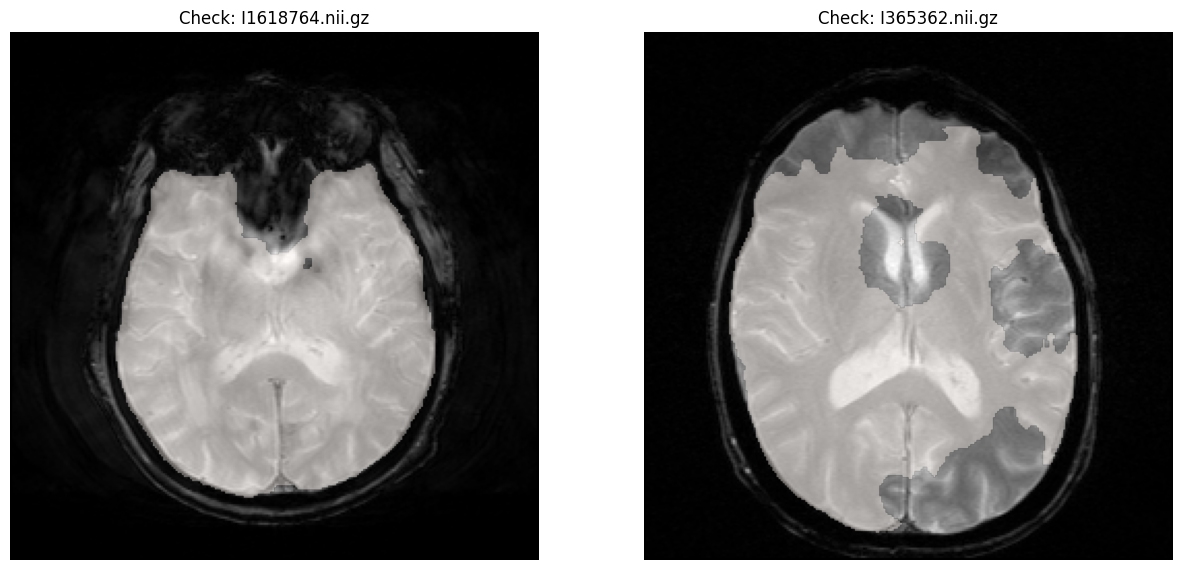

In [16]:
import nibabel as nib
import matplotlib.pyplot as plt
import numpy as np
import os
import random

# Rutas
INPUT_DIR = "/media/PORT-DISK/Practicas/MicroBleeds_Generation/workdir/raw/positives"
MASK_DIR = "/media/PORT-DISK/Practicas/MicroBleeds_Generation/workdir/masks/positives"

def check_results(n_samples=2):
    files = [f for f in os.listdir(INPUT_DIR) if f.endswith(".nii.gz")]
    # Filtrar solo los que ya tienen máscara generada
    files = [f for f in files if os.path.exists(os.path.join(MASK_DIR, f.replace(".nii.gz", "_mask.nii.gz")))]
    
    if not files:
        print("No se encontraron máscaras generadas aún.")
        return

    seleccionados = random.sample(files, min(n_samples, len(files)))
    fig, axes = plt.subplots(1, len(seleccionados), figsize=(15, 7))
    if len(seleccionados) == 1: axes = [axes]

    for i, filename in enumerate(seleccionados):
        img = nib.load(os.path.join(INPUT_DIR, filename)).get_fdata()
        mask = nib.load(os.path.join(MASK_DIR, filename.replace(".nii.gz", "_mask.nii.gz"))).get_fdata()
        
        # Corte axial medio
        idx = img.shape[2] // 2
        axes[i].imshow(np.rot90(img[:, :, idx]), cmap='gray')
        
        # Superponer máscara roja
        mask_overlay = np.ma.masked_where(mask[:, :, idx] == 0, mask[:, :, idx])
        axes[i].imshow(np.rot90(mask_overlay), cmap='Reds', alpha=0.4)
        axes[i].set_title(f"Check: {filename}")
        axes[i].axis('off')
    
    plt.show()

check_results(2)